In [7]:
%matplotlib inline


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

In [3]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [4]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [5]:
print(len(trainset))
print(len(testset))

60000
10000


### Visualize the dataset

tensor(5) tensor(3) tensor(9) tensor(6) tensor(3) tensor(0) tensor(9) tensor(1) tensor(7) tensor(7) tensor(2) tensor(1) tensor(1) tensor(3) tensor(4) tensor(5)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0ce57305f8>>
Traceback (most recent call last):
  File "/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/anass/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/anass/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/anass/anaconda3/envs/c

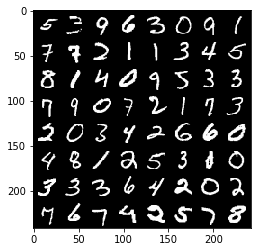

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [10]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device('cuda:0' if use_cuda else "cpu")
print(device)

cuda:0


### Define a Conv Net


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [12]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [13]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [14]:
train(5)  # train 5 epochs should get you to about 97% accuracy

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294673
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.320497
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.294236
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.281769
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.223257
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.066359
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.877176
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.468623
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.346443
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.420423


/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7427, Accuracy: 8164/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.731582
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.313103
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.607204
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.299926
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.260662
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.243223
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.285318
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.152853
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.318827

Test set: Average loss: 0.2397, Accuracy: 9308/10000 (93%)

Train Epoch: 2 [1536/60000 (3%)]	Loss: 0.094622
Train Epoch: 2 [7936/60000 (13%)]	Loss: 0.229317
Train Epoch: 2 [14336/60000 (24%)]	Loss: 0.464209
Train Epoch: 2 [20736/60000 (35%)]	Loss: 0.100063
Train Epoch: 2 [27136/60000 (45%)]	Loss: 0.078566
Train Epoch: 2 [33536/60000 (56%)]	Loss: 0.134604
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.134544
Train Epoch: 2 [46336/60000 (77%)]	Loss: 0.101704
Train Epoch: 2 [52736/60000 (88%)

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [15]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [17]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.3049, Accuracy: 1210/10000 (12%)



### Define a training loop with model checkpointing

In [18]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [19]:
train_save(5, 500, 100)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301978
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.289980
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.275612
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.221203
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.094723
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.825642
model saved to mnist-500.pth
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.634106
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.275441
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.051237
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.185533


/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6297, Accuracy: 8327/10000 (83%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.405627
model saved to mnist-1000.pth
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.407475
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.288973
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.257831
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.542788
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.550615
model saved to mnist-1500.pth
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.498131
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.258450
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.526020

Test set: Average loss: 0.2471, Accuracy: 9270/10000 (93%)

Train Epoch: 2 [1536/60000 (3%)]	Loss: 0.202460
Train Epoch: 2 [7936/60000 (13%)]	Loss: 0.202235
model saved to mnist-2000.pth
Train Epoch: 2 [14336/60000 (24%)]	Loss: 0.303165
Train Epoch: 2 [20736/60000 (35%)]	Loss: 0.235482
Train Epoch: 2 [27136/60000 (45%)]	Loss: 0.271810
Train Epoch: 2 [33536/60000 (56%)]	Loss: 0.269216
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.

In [20]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

model loaded from mnist-4690.pth


/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1171, Accuracy: 9649/10000 (96%)



## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [21]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [23]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
train(1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.995211
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.616115
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.855369
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.481979
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.534176
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.418956
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.463001
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.465124
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.358084
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.429464


/home/anass/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1738, Accuracy: 9480/10000 (95%)



### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!